In [1]:
import warnings
warnings.filterwarnings("ignore")
import pickle
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import os
import sys
sys.path.append("./../../pyfiles/")
from dataset import *
from util import *
from model import *
from WaveGlow import *

---

<font size="5">Overviews</font>
1. Introduction
1. Preparation
1. Activation Maximization

---

# Introduction
---
This is the main topic of this experiment; Activation Maximization in mel-spectrogram domain using a prior.
As I've mentioned, this experiment is conducted to observe the reason why the classifier classifies the audio as a certain domain and 
what makes the audio angry, for example.
Instead of updating the input audio, the noise vector which is inserted into the generator is updated as shown below. 
The classifier's input will be a mel-spectrogram.
In this notebook, I'm going to employ the generator of GAN.

<img src="./../data/images/AM_with_prior.png" width="800">

---
set some parameters as previous

---

In [3]:
emotions = ["neutral", "happy", "sad", "angry"] # the labels of classes
classes = tuple(range(len(emotions))) # classes tuple
fs = 22050
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Preparation
In this section, I prepared some variables, functions, and models.

## Model
---
First of all, I defined the model and called the trained parameters in the previous notebook.

---

- Classifier

In [4]:
# ----- adjustable parameters ----- #
args = {}
args["wavenet"] = {}
args["wavenet"]["layer_num"] = 5
args["wavenet"]["resnch_in"] = 16 # the input channels in residual block
args["wavenet"]["resnch_hidden"] = int(args["wavenet"]["resnch_in"]/2) # the hidden channels in residual block
args["wavenet"]["resnch_out"] = args["wavenet"]["resnch_hidden"] * 2 # the output channels in residual block
args["wavenet"]["nch_hidden"] = args["wavenet"]["resnch_out"] * 2 # the hidden channels in stack-CNN layers following the residual block
args["wavenet"]["nch_out"] = len(classes) # the output channels, # of classes
args["wavenet"]["reduce"] = 2 # kernel size of max pooling layer
args["wavenet"]["nch_in"] = 80 # input channels
args["wavenet"]["prefilter"] = 3 # kernel size of the pre-convolutional layer
args["wavenet"]["filter_list"] = [3] * args["wavenet"]["layer_num"] # filter size of the convolutional layers
args["wavenet"]["dilation_list"] = [2**i for i in range(10)] * (args["wavenet"]["layer_num"]//10) + [2**i for i in range(args["wavenet"]["layer_num"]%10)] # dilation in ResudualNet
args["wavenet"]["num_cls"] = 3 # # of layer in stach-CNN layers
args["wavenet"]["bidirectional"] = True # bi-directional or not
args["wavenet"]["model_path"] = "../data/parameters/mel_emotion_classifier_biwavenet_nchin80_prefilter3_res_in16_hidden8_out16_nchhidden32_nchout4_wavenetln5_fsize3_reduce2_cnnnum3_epoch192.pth"
    
args["lstm"] = {}
args["lstm"]["nch"] = 64
args["lstm"]["lstm_in_nch"] = int(args["lstm"]["nch"]/2)
args["lstm"]["pre_filter_kernel"] = 3
args["lstm"]["reduce"] = 2 # compression size in each CNN layers
args["lstm"]["num_cls"] = 1 # # of layer in stach-CNN layers
args["lstm"]["bidirectional"] = True # bi-directional or not
args["lstm"]["num_lstm_layers"] = 5
args["lstm"]["model_path"] = "../data/parameters/mel_emorec_fs22050_bilstm_nch64_cnnnums1_reduce2_prefilter3_lstmin32_lstmnum5_epoch279.pth"
    
args["cnn"] = {}
args["cnn"]["layer_num"] = 3
args["cnn"]["nch"] = 64
args["cnn"]["model_path"] = "../data/parameters/mel_emotion_classifier_CNN_layer_num3_nch64_epoch273.pth"
# --------------------------------- #

---
To obtain the result efficiently, I first defined the function which calls the classifier easily.

---

In [5]:
def call_model(args, model_type, pretrain=True):
    if model_type=="wavenet":
        net = WaveNet_classifier_mel(args["wavenet"]["resnch_in"], args["wavenet"]["resnch_hidden"], args["wavenet"]["resnch_out"], args["wavenet"]["nch_hidden"], args["wavenet"]["nch_out"], 
                                 args["wavenet"]["filter_list"], args["wavenet"]["dilation_list"], 160, args["wavenet"]["reduce"], args["wavenet"]["num_cls"], args["wavenet"]["prefilter"], args["wavenet"]["nch_in"], args["wavenet"]["bidirectional"])
        net.eval()
    elif model_type=="lstm":
        net = LSTM_classifier_mel(80, len(classes), args["lstm"]["nch"], args["lstm"]["bidirectional"], args["lstm"]["num_cls"], args["lstm"]["reduce"], args["lstm"]["num_lstm_layers"], 
                              160, args["lstm"]["pre_filter_kernel"], args["lstm"]["lstm_in_nch"])
        net.train()
    elif model_type=="cnn":
        net = CNN_classifier_mel(1, len(classes), args["cnn"]["layer_num"], args["cnn"]["nch"])
        net.eval()
    net = net.to(device)
    if pretrain:
        model_ = torch.load(args[model_type]["model_path"])
        net.load_state_dict(model_)
        
    for model in [net]:
        layer_list = list(model.state_dict())
        for layer in layer_list:
            try :
                model.state_dict()[layer].requires_grad = False
            except RuntimeError:
                continue
    return net

- Generator

In [6]:
lbd = {}
lbd["consisreg"] = 0.1
ndim = 512
load_epoch = 300
unrolled_k = 5
# gen_path = f"../data/parameters/gen_celebA_unrolled{unrolled_k}_ndim{ndim}_lbd_consisreg{lbd['consisreg']}_epoch{load_epoch}.pth"
gen_path = f"../data/parameters/gen_celebA_unrolled{unrolled_k}_ndim{ndim}_lbd_consisreg{lbd['consisreg']}_epoch{load_epoch}.pth"

In [7]:
generator = Generator_mel(ndim=ndim, nch_output=1)
generator = generator.to(device)
generator.eval()
gen_model = torch.load(gen_path)
generator.load_state_dict(gen_model)

<All keys matched successfully>

- WaveGlow

In [8]:
model_path = "../data/parameters/waveglow_official.pth"
waveglow = call_waveglow(model_path)

---
Make the model able to backpropagate.

---

In [9]:
for model in [generator]:
    layer_list = list(model.state_dict())
    for layer in layer_list:
        try :
            model.state_dict()[layer].requires_grad = False
        except RuntimeError:
            continue

## Some Variables and Functions
---
There are some variables and functions I need to define to conduct the activation maximization.
For the sake of appearance of the code, I first implemented 3 modules: "my_transform", "my_loss_waveform", and "Activation_Maximization",
which indicate a transformer, getting loss function, and the mail part of training respectively.

---

In [10]:
class my_transform(torch.autograd.Function):
    @staticmethod
    def forward(ctx, data):
        ctx.save_for_backward(data)
        return data[:, :target_length]
    
    @staticmethod
    def backward(ctx, grad_output):
        data, = ctx.saved_tensors
        grad_input = F.pad(grad_output, (0, data.shape[1]-target_length, 0, 0))
        return grad_input

In [11]:
def my_loss_waveform(array, noise_vector, model, class_num, lbd_l1=1, lbd_l2=1, lbd_undesired=1, show_losses=True):
    shape = array.shape
    score = model(array)
    desired_output = score[:, class_num]
    undesired_output = (torch.sum(score[:, :]) - desired_output) / (score.shape[1]-1)
    l1 = torch.sum(torch.abs(noise_vector), axis=(1,2,3)) / shape[2]
    l2 = torch.sum((noise_vector)**2, axis=(1,2,3)) / shape[2]
    if show_losses:
        print("desired score loss", desired_output.detach().to("cpu").numpy())
        print("undesired score loss", undesired_output.detach().to("cpu").numpy())
        print("L1:regularization", l1.detach().to("cpu").numpy())
        print("L2:regularization", l2.detach().to("cpu").numpy())

    losses = - desired_output + lbd_undesired*undesired_output + lbd_l2 * l2 + lbd_l1 * l1
    return torch.mean(losses)

In [12]:
class Activation_Maximization():
    def __init__(self, model, generator, ndim, lbd, epoch_num, lr_base, classes, device, graph_visualization=False, show_losses=True):
        self.model = model
        self.generator = generator
        self.ndim = ndim
        self.lbd = lbd
        self.epoch_num = epoch_num
        self.lr_base = lr_base
        self.classes = classes
        self.device = device
        self.display_epoch = display_epoch
        self.graph_visualization = graph_visualization
        self.show_losses = show_losses
        self.target_class = None
        self.noise_vector = None
        self.mel = None
        self.losses = 0
        
    def _get_data_dic(self):
        data = {}
        data["noise"] = []
        data["mel"] = []
        data["prediction"] = []
        data["max_score"] = []
        data["desired_score"] = []
        return data
    
    def _my_loss(self):
        shape = self.mel.shape
        score = self.model(self.mel)
        desired_output = score[0, self.target_class]
        undesired_output = (torch.sum(score[0, :]) - desired_output) / (score.shape[1]-1)
        
        l1 = torch.sum(torch.abs(self.noise_vector)) / shape[2] / shape[3] 
        l2 = torch.sum((self.noise_vector)**2) / shape[2] / shape[3]
        
        if self.show_losses:
            print("desired score loss", -cuda2numpy(desired_output))
            print("undesired score loss", cuda2numpy(undesired_output))
            print("L1:regularization", cuda2numpy(l1))
            print("L2:regularization", cuda2numpy(l2))
            
        return - desired_output + self.lbd["undesired"]*undesired_output + self.lbd["l2"]*l2 + self.lbd["l1"]*l1
    
    def _stock(self, data, epoch):
        score = cuda2numpy(F.softmax(self.model(self.mel)))
        max_index = np.argmax(score)
        if epoch in self.display_epoch:
            data["noise"].append(cuda2numpy(self.noise_vector))
            data["mel"].append(cuda2numpy(self.mel))
            data["prediction"].append(max_index)
            data["max_score"].append(score[0,max_index])
            data["desired_score"].append(score[0,self.target_class])
        
        print("epoch", epoch)
        print("prediction: ", score[0][max_index], emotions[max_index],)
        print("target    : ", score[0][self.target_class], emotions[self.target_class],)
        
        return data
    
    def get(self, target_class, noise=None):
        losses = []
        self.target_class = target_class
        data = self._get_data_dic()
        if type(noise) is np.ndarray:
            self.noise_vector = torch.Tensor(noise).to(device)
        else:
            self.noise_vector = torch.Tensor(np.random.randn(1, self.ndim, 1, 1)).to(device)
        self.noise_vector.requires_grad = True
        label = torch.tensor([target_class]*1, dtype=torch.int64)

        optimizer = my_adam_waveform()
        
        for epoch in range(self.epoch_num):
            
            self.mel = self.generator(self.noise_vector)
            
            data = self._stock(data, epoch)
            lr = my_scheduler(lr_base, epoch, 0.99)
            loss = self._my_loss()
            self.noise_vector = optimizer.update(self.noise_vector, loss, lr)

            losses.append(cuda2numpy(loss))
            
            clear_output(wait=True)
            if self.graph_visualization:
                fig = plt.figure(figsize=(12,6))
                ax = fig.add_subplot(1,2,1)
                ax.plot(losses)
                ax.set_title("loss")
#                 ax = fig.add_subplot(1,2,2)
#                 ax.plot(cuda2numpy(self.averaged_mask)[0][0])
                plot_spectrogram(cuda2numpy(self.mel)[0][0], fig, (1,2,2))
                ax.set_title("spectrogram")
                plt.show()
            
        self.losses = losses
        return data

---
Next, some parameters for training.

---

In [13]:
# ----- adjustable parameters ----- #
epoch_num = 301 # epoch num
display_num = 15 # # of saved data
lr_base = 0.01 # base learning rate
lbd = {}
lbd["l1"] = 0 # L1 loss
lbd["l2"] = 100 # L2 loss
lbd["undesired"] = 1. # loss for being not classified as undesired output
# --------------------------------- #

display_epoch = np.sort(np.array(list(set([int(np.exp(i)) for i in np.linspace(-1, np.log(epoch_num), num=display_num)]))))

# Activation Maximization
---
Ok, so let's search for the appropriate noise vector for a specific emotion.

---

## One sample
---
First of all, I tried just one sample.

---

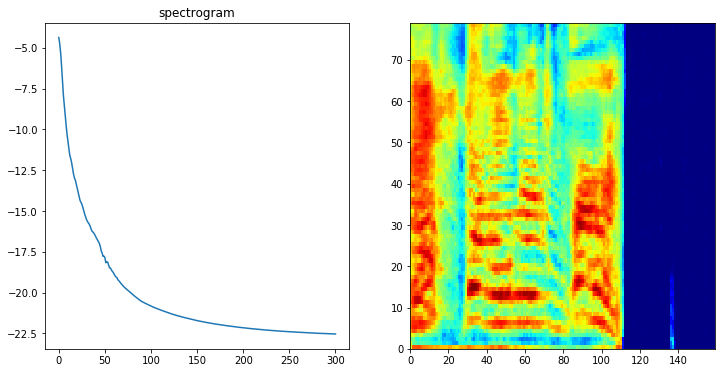

In [14]:
# ----- adjustable parameters ----- #
graph_visualization = True # visualize graph while training or not
show_losses = True # visualize the detail of losses or not

model_type = "cnn" # the choices are "cnn", "wavenet", and "lstm".
target_class = 3
# --------------------------------- #

classifier = call_model(args, model_type)
am = Activation_Maximization(classifier, generator, ndim, lbd, epoch_num, lr_base, classes, device, graph_visualization, show_losses)
noise_vector = np.random.randn(1, ndim, 1, 1)

# optimization
data = am.get(target_class, noise_vector)

---
Let's see the initial data and the optimized data.

---

angry


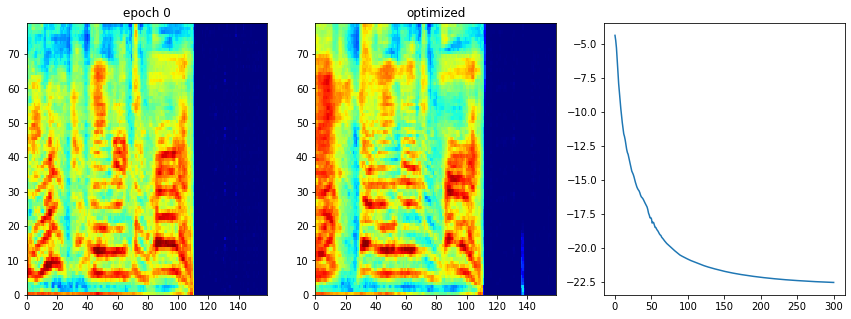

In [15]:
print(emotions[target_class])
fig = plt.figure(figsize=(25,5))
plot_spectrogram(data["mel"][0][0][0], fig, (1,5,1), title="epoch 0")
plot_spectrogram(data["mel"][-1][0][0], fig, (1,5,2), title="optimized")
ax = fig.add_subplot(1, 5, 3)
ax.plot(am.losses)
plt.show()

mel = torch.tensor(data["mel"][0][0]).to(device)
audio, noise = audio_generation(mel, waveglow)
play_audio(audio, fs)

mel = torch.tensor(data["mel"][-1][0]).to(device)
audio, noise = audio_generation(mel, waveglow)
play_audio(audio, fs)

## All samples
---
Ok, so let's get the results in all emotions and models.

---

In [17]:
# ----- adjustable parameters ----- #
graph_visualization = False # visualize graph while training or not
show_losses = False # visualize the detail of losses or not
sample_num = 100 # the number of sample data
# --------------------------------- #

In [18]:
all_data = {}
for model_type in ["cnn", "wavenet", "lstm"]:
# for model_type in ["lstm"]:
    classifier = call_model(args, model_type)
    am = Activation_Maximization(classifier, generator, ndim, lbd, epoch_num, lr_base, classes, device, graph_visualization, show_losses)
    all_data[model_type] = {}
    
    for target_class in classes:
        all_data[model_type][emotions[target_class]] = []
    for target_class in classes:
        for i in range(sample_num):
            np.random.seed(i)
            noise_vector = np.random.randn(1, ndim, 1, 1)
            all_data[model_type][emotions[target_class]].append(am.get(target_class, noise_vector))

epoch 300
prediction:  1.0 angry
target    :  1.0 angry


---
You can choose the emotion and the model type to show the results.

---

angry


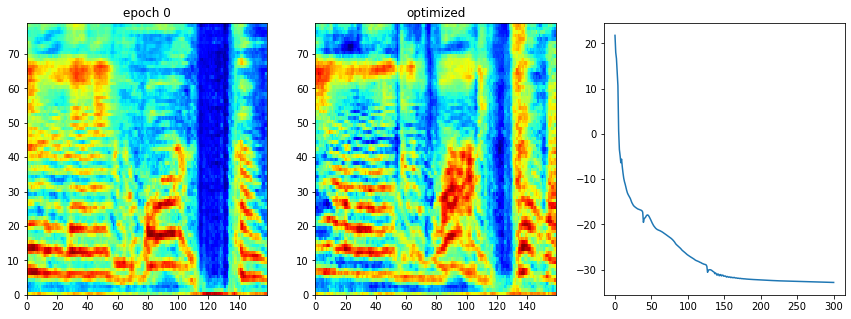

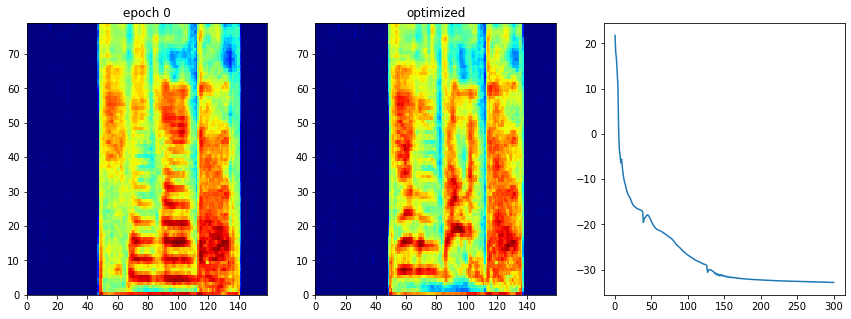

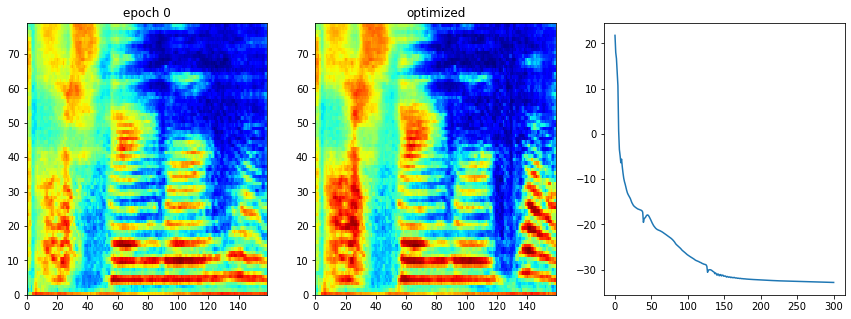

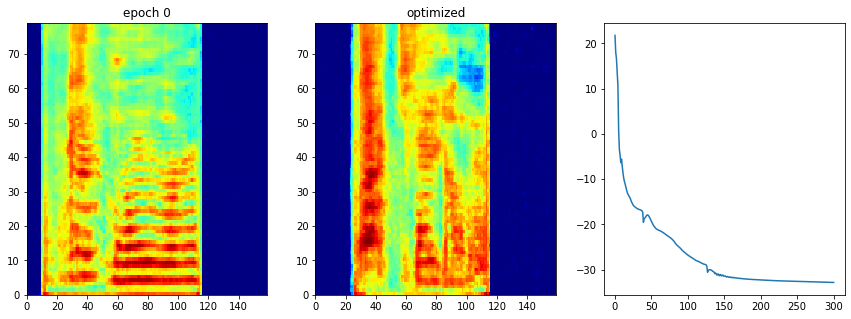

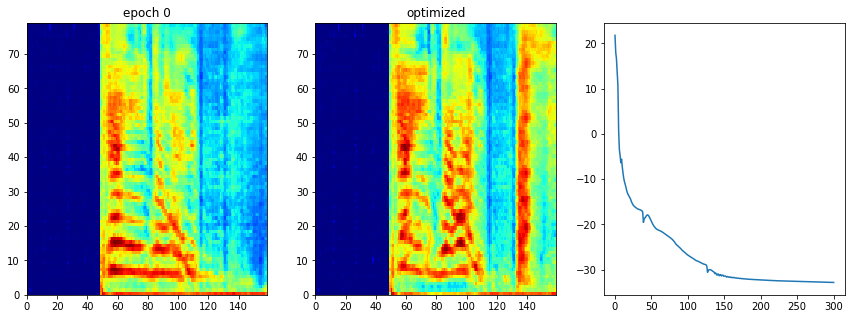

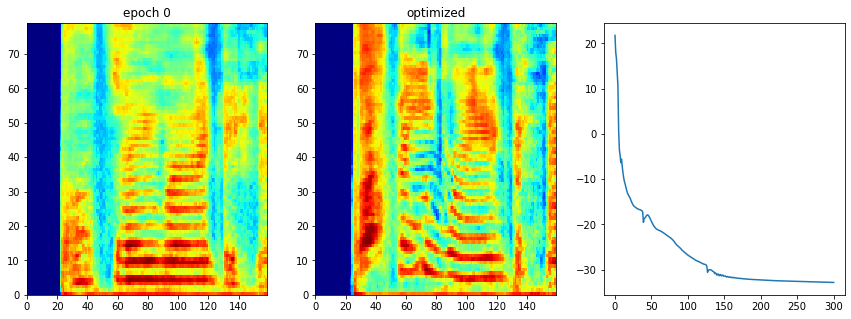

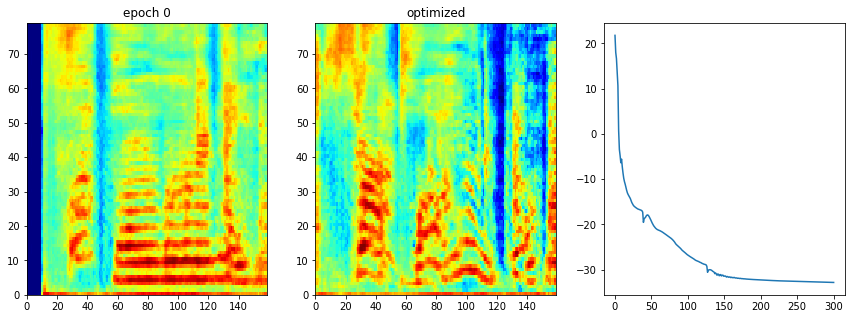

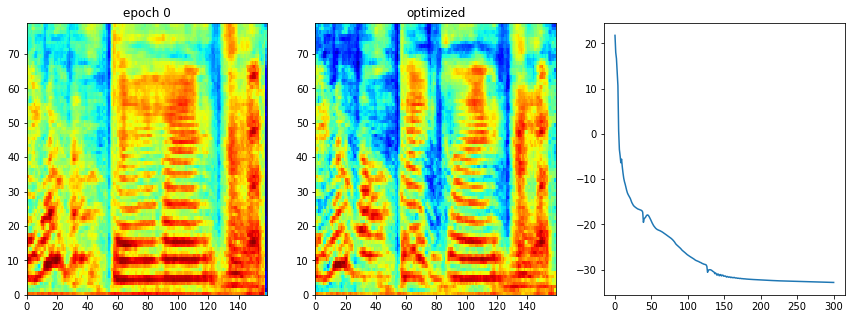

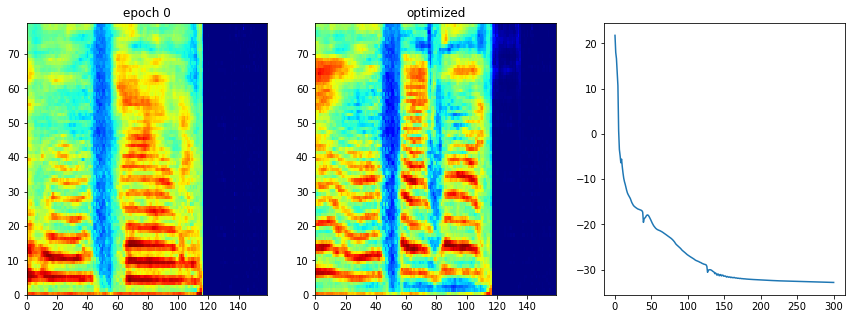

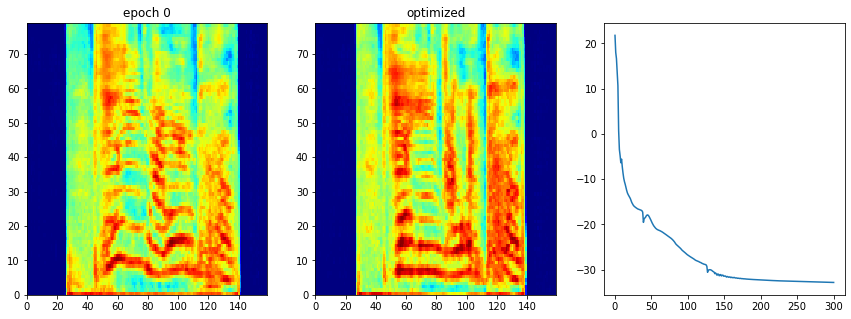

In [19]:
# ----- adjustable parameters ----- #
emotion = "angry"
model_type = "cnn"
# --------------------------------- #

data = all_data[model_type][emotion]

print(emotion)
for i in range(len(data)):
    fig = plt.figure(figsize=(25,5))
    plot_spectrogram(data[i]["mel"][0][0][0], fig, (1,5,1), title="epoch 0")
    plot_spectrogram(data[i]["mel"][-1][0][0], fig, (1,5,2), title="optimized")
    ax = fig.add_subplot(1, 5, 3)
    ax.plot(am.losses)
    plt.show()

    mel = torch.tensor(data[i]["mel"][0][0]).to(device)
    audio, noise = audio_generation(mel, waveglow)
    play_audio(audio, fs)

    mel = torch.tensor(data[i]["mel"][-1][0]).to(device)
    audio, noise = audio_generation(mel, waveglow)
    play_audio(audio, fs)

---
At the moment, I'm able to compare the results among the models mentioned in only this notebook. Overall analysis and further comparison will be carried out in `06_result_GAN_AM.ipynb`. So please save the data with the code below.

---

In [19]:
# ----- adjustable parameters ----- #
root = "./../data/results/"
root_model = root + "GAN_100/"
save = True
# --------------------------------- #

os.makedirs(root, exist_ok=True)
os.makedirs(root_model, exist_ok=True)

for model_type in ["cnn", "wavenet", "lstm"]:
    model_name = f"mel_{model_type}"
    base_dir = root_model + model_name + "/"
    base_dir = root_model + model_name + "/"
    os.makedirs(base_dir, exist_ok=True)
    save_path = base_dir + "results_" + model_name + ".pkl"
    if save:
        with open(save_path, mode='wb') as f:
            pickle.dump(all_data[model_type], f)